In [1]:
from quality_metrics import (
    angular_resolution,
    aspect_ratio,
    crossing_angle,
    crossing_number,
    gabriel_graph_property,
    ideal_edge_length,
    node_resolution,
    run_time,
    shape_based_metrics,
    stress,
)

# d = "les_miserables"
# d = "1138_bus"
d = "USpowerGrid"
# l = "SS"
l = "FR"



In [2]:
QUALITY_METRICS = {
    "angular_resolution": angular_resolution,
    "aspect_ratio": aspect_ratio,
    "crossing_angle": crossing_angle,
    "crossing_number": crossing_number,
    "gabriel_graph_property": gabriel_graph_property,
    "ideal_edge_length": ideal_edge_length,
    "node_resolution": node_resolution,
    "run_time": run_time,
    "shape_based_metrics": shape_based_metrics,
    "stress": stress,
}

ALL_QUALITY_METRICS_NAMES = sorted([name for name in QUALITY_METRICS])

import os

os.makedirs(f"images/c_r_o/{l}/{d}", exist_ok=True)

In [3]:
import pandas as pd

rpfs_df = pd.read_pickle(f"data/n_rpfs/{l}/{d}/ignore_20rp_50fs.pkl")
opfs_df = pd.read_pickle(f"data/n_opfs/{l}/{d}/ignore_all.pkl")

In [4]:
import matplotlib.pyplot as plt


In [5]:
q_opfs = {}

for name in ALL_QUALITY_METRICS_NAMES:
    q_opfs[name] = []


for name in ALL_QUALITY_METRICS_NAMES:
    tdf = opfs_df[opfs_df['target'] == name]
    for q in tdf['quality_metrics']:
        q_opfs[name].append(q[name])


In [6]:
q_rpfs = {}

for name in ALL_QUALITY_METRICS_NAMES:
    q_rpfs[name] = []

q_tmp = {}
for s, q in zip(rpfs_df["n_seed"], rpfs_df["quality_metrics"]):
    if s == 0:
        for name in ALL_QUALITY_METRICS_NAMES:
            q_tmp[name] = []
    for name in ALL_QUALITY_METRICS_NAMES:
        q_tmp[name].append(q[name])
    if s == 49:
        for name in ALL_QUALITY_METRICS_NAMES:
            q_rpfs[name].append(q_tmp[name])

In [7]:
import statistics
import numpy as np
import json

export_directory = f'data/optimized/{l}/{d}'
os.makedirs(export_directory, exist_ok=True)


optimized = []
counts = {}

opfs_mean = {}
rpfs_means = {}

border = 18

for name in ALL_QUALITY_METRICS_NAMES:
    direction = QUALITY_METRICS[name].direction
    opfs_mean[name] = statistics.median(q_opfs[name])
    count = 0

    if name not in rpfs_means:
        rpfs_means[name] = []
    for vs in q_rpfs[name]:
        rpfs_means[name].append(statistics.median(vs))

    for mean in rpfs_means[name]:
        if direction == "maximize":
            if mean <= opfs_mean[name]:
                count += 1
        elif direction =='minimize':
            if opfs_mean[name] <= mean:
                count += 1
    if border <= count:
        optimized.append(name)
    counts[name] = count

dict_data = {
    'optimized': optimized,
    'counts': counts
}
with open(f'{export_directory}/quality_metrics.json', mode='w') as f:
    json.dump(dict_data, f)

/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1285: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1286: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


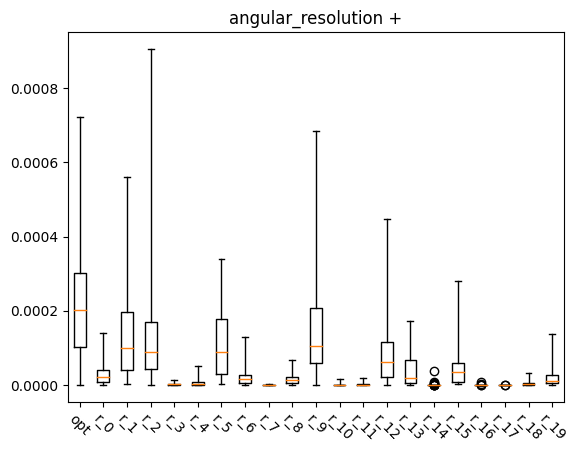

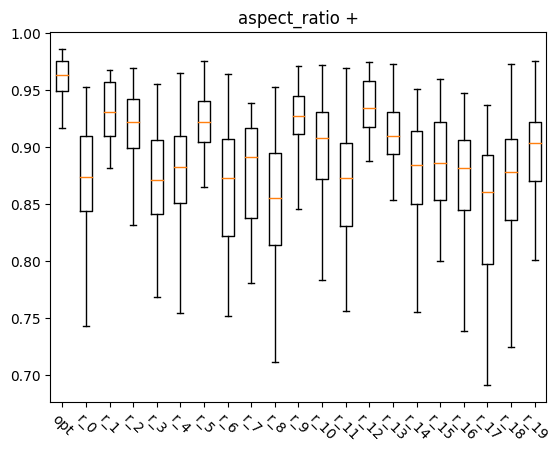

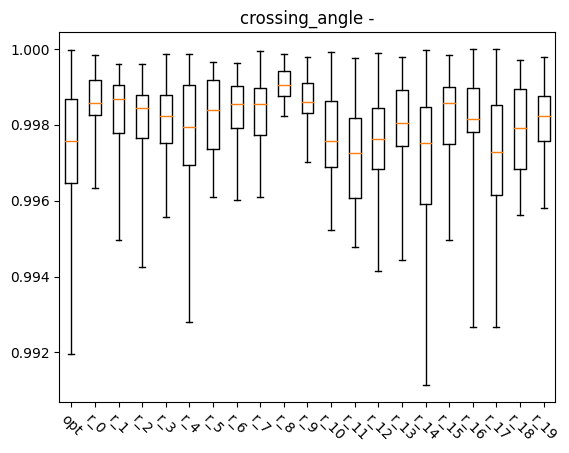

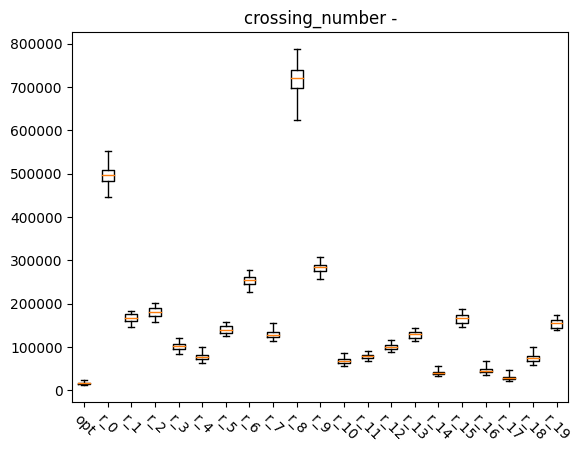

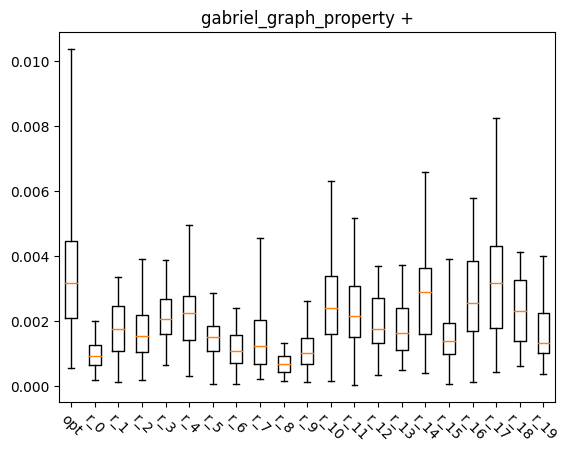

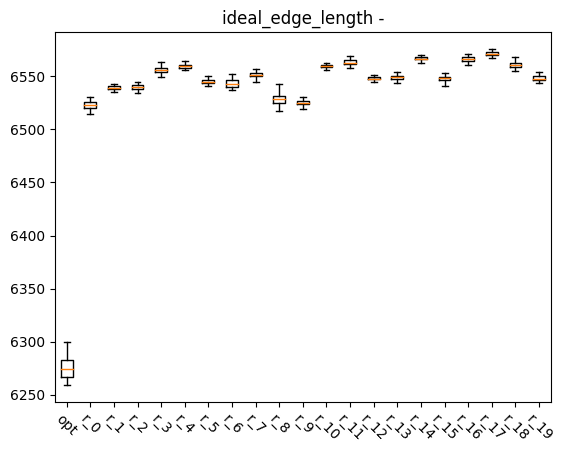

/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1285: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1286: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


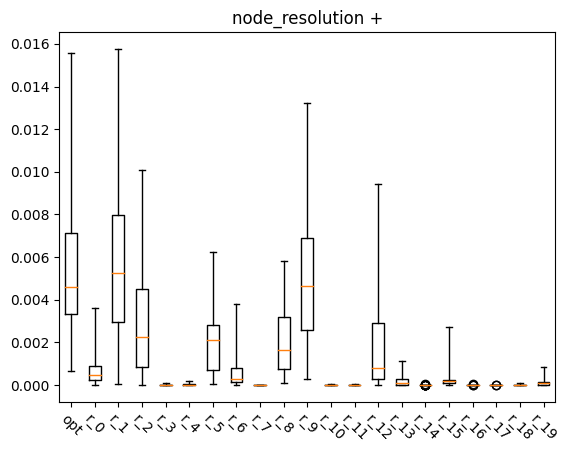

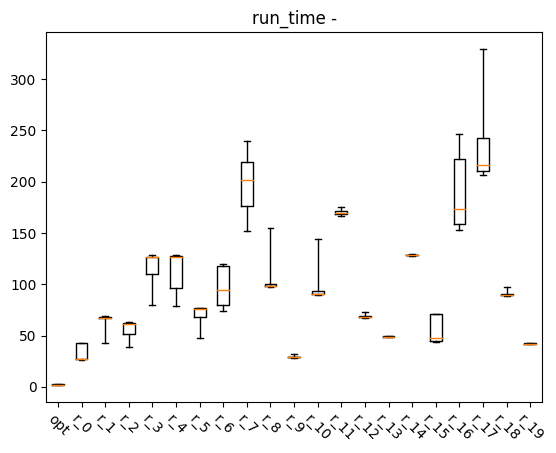

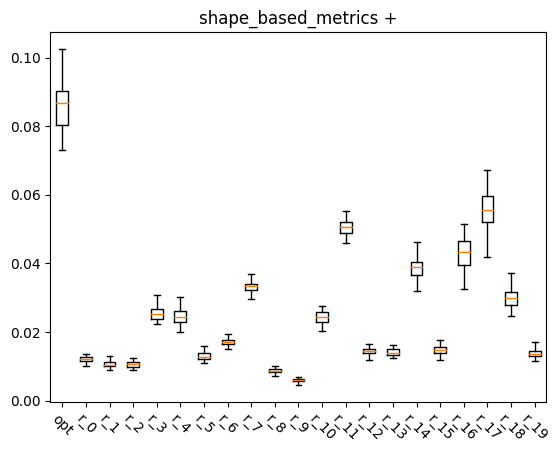

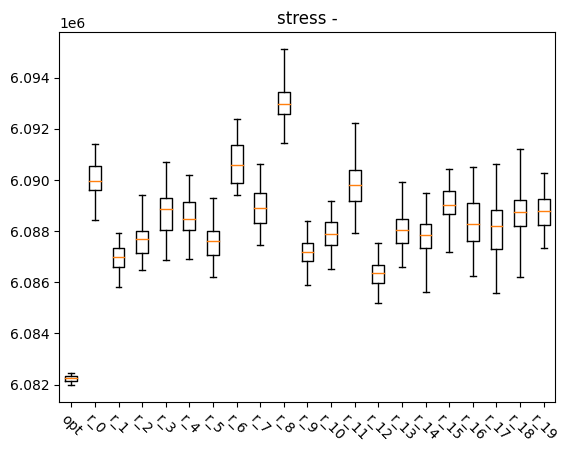

In [8]:
for name in ALL_QUALITY_METRICS_NAMES:
    bins = [q_opfs[name], *q_rpfs[name]]
    direction = QUALITY_METRICS[name].direction
    plt.title(f'{name} {"+" if direction == "maximize" else "-"}')
    plt.boxplot(
        bins,
        labels=[f"opt"] + [f"r_{n}" for n in range(len(q_rpfs[name]))],
        whis=float("inf"),
    )
    plt.xticks(rotation=-45, ha="center")
    plt.savefig(
        f"images/c_r_o/{l}/{d}/{name}.png",
        format="png",
        dpi=300,
        facecolor="white",
    )
    plt.show()

In [9]:
from PIL import Image, ImageDraw, ImageFont

images_directory = f'images/c_r_o/{l}/{d}'
export_path = f"{images_directory}/all.png"

images = []
tmp = []
for quality in ALL_QUALITY_METRICS_NAMES:
    image_path = f"{images_directory}/{quality}.png"
    img = Image.open(image_path)

    tmp.append({'image': img})

    if len(tmp) == 5:
        images.append(tmp)
        tmp = []


def get_concat_h(im1, im2):
    dst = Image.new("RGB", (im1.width + im2.width, im1.height), 'black')
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def get_concat_v(im1, im2):
    dst = Image.new("RGB", (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_h_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (max(im1.width, im2.width), im1.height + im2.height), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

dst = None
for v in images:
    h_dst = None
    for h in v:
        if h_dst is None:
            h_dst = h["image"]
            continue
        h_dst = get_concat_h_blank(h_dst, h["image"])
    if dst is None:
        dst = h_dst
        continue
    dst = get_concat_v_blank(dst, h_dst)

dst.save(export_path)
# os.removedirs(images_export_directory)